In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/Capstone/

/content/gdrive/MyDrive/Capstone


In [ ]:

# install
!pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf

import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla P100-PCIE-16GB'

In [ ]:
twitter = pd.read_csv("./20220128_labels_renewed.csv")


In [ ]:
import string as st
lemmatizer = WordNetLemmatizer()
stopword = nltk.corpus.stopwords.words('english')
def pre_processing(text):
    a = [w for w in text if w not in st.punctuation]
    text = ''.join(a)
    texts = nltk.word_tokenize(text)
    a = [w for w in texts if w not in stopword]
    a = [x.lower() for x in a]
    a = [i for i in a if not i.isdigit()]
    
    a = [lemmatizer.lemmatize(w) for w in a]
    return ' '.join(a)


In [ ]:
twitter = twitter[twitter['Text'].notna()]
twitter['CleanText'] = twitter['Text'].apply(pre_processing)
twitter

,Text,Type of Tweet,Resource Mentioned,Second Resource,Third Resource,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,CleanText
0,New York AG suggests emergency housing for bas...,advice,shelter,NaN,NaN,NaN,food,134.0,NaN,demand,231.0,new york ag suggests emergency housing basemen...
1,"The Cajun Army will head to Chauvin, LA on Sat...",demand,food,NaN,NaN,NaN,electricity,106.0,NaN,advice,68.0,the cajun army head chauvin la saturday humani...
2,NEWS: The Indianapolis Fraternal Order of Poli...,resources,food,NaN,NaN,NaN,shelter,105.0,NaN,resources,156.0,news the indianapolis fraternal order police d...
3,Keep an eye on local news and municipal announ...,resources,food,shelter,NaN,NaN,medical,103.0,NaN,announcement,45.0,keep eye local news municipal announcement pod...
4,Calling all volunteers! The @HoustonFoodBank n...,demand,volunteers,NaN,NaN,NaN,vonlunteers,5.0,NaN,NaN,NaN,calling volunteer the houstonfoodbank need hel...
...,...,...,...,...,...,...,...,...,...,...,...,...
495,@POTUS As a Louisianan who is currently living...,demand,electricity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,potus a louisianan currently living power wate...
496,President Tate shares a message as students re...,resources,medical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,president tate share message student return ca...
497,All residents impacted by Ida can preregister ...,resources,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,all resident impacted ida preregister dsnap di...
498,"As #HurricaneIda moves through Louisiana, ever...",advice,shelter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a hurricaneida move louisiana everyone around ...


In [ ]:
types_df = twitter[['CleanText', 'Type of Tweet']]
res_df = twitter[['CleanText', 'Resource Mentioned']]

In [ ]:
res_df['Resource Mentioned'].value_counts()

food              134
electricity       106
shelter           105
medical           103
fund               16
supplies           15
pet                 9
gas                 6
volunteers          5
transportation      1
Name: Resource Mentioned, dtype: int64

In [ ]:
tweets = res_df['CleanText']
labels = res_df[['Resource Mentioned']].replace(['electricity','food','shelter', 'medical', 'fund', 'supplies', 'pet', 'gas', 'volunteers', 
                                                 'transportation'],[0,1,2,3,4,5,6,7,8,9]) 

tweets = ["[CLS] " + query + " [SEP]" for query in tweets]

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in tweets]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'new', 'york', 'ag', 'suggests', 'emergency', 'housing', 'basement', 'dwell', '##er', 'city', 'ida', 'death', 'hurricane', '##ida', 'ny', 'https', '##tc', '##ou', '##q', '##7', '##j', '##5', '##p', '##na', '##aw', '[SEP]']


In [ ]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [ ]:

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
# !pip install fast_ml
# from fast_ml.model_development import train_valid_test_split

# train_inputs, train_labels, validation_inputs, validation_labels, test_inputs, test_labels = train_valid_test_split(input_ids, target = labels, random_state=2018, train_size=0.8, valid_size=0.1, test_size=0.1)

train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, random_state=2018, test_size=1/9)

train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(train_masks, train_masks, random_state=2018, test_size=1/9)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)
train_labels = torch.tensor(train_labels.to_numpy())
validation_labels = torch.tensor(validation_labels.to_numpy())
test_labels = torch.tensor(test_labels.to_numpy())
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=10)
model.cuda()

100%|██████████| 407873900/407873900 [00:10<00:00, 38272908.91B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.9064358106026282


Epoch:   5%|▌         | 1/20 [00:06<02:03,  6.50s/it]

Validation Accuracy: 0.3315972222222222
Train loss: 1.4109632418705866


Epoch:  10%|█         | 2/20 [00:12<01:55,  6.40s/it]

Validation Accuracy: 0.7204861111111112
Train loss: 0.8810463272608243


Epoch:  15%|█▌        | 3/20 [00:19<01:48,  6.36s/it]

Validation Accuracy: 0.7482638888888888
Train loss: 0.7417141978557293


Epoch:  20%|██        | 4/20 [00:25<01:41,  6.34s/it]

Validation Accuracy: 0.7482638888888888
Train loss: 0.5539658631269748


Epoch:  25%|██▌       | 5/20 [00:31<01:35,  6.34s/it]

Validation Accuracy: 0.7638888888888888
Train loss: 0.41470539569854736


Epoch:  30%|███       | 6/20 [00:38<01:28,  6.33s/it]

Validation Accuracy: 0.7916666666666667
Train loss: 0.3144658993069942


Epoch:  35%|███▌      | 7/20 [00:44<01:22,  6.33s/it]

Validation Accuracy: 0.8350694444444444
Train loss: 0.28794815792487216


Epoch:  40%|████      | 8/20 [00:50<01:15,  6.33s/it]

Validation Accuracy: 0.8628472222222222
Train loss: 0.225272770684499


Epoch:  45%|████▌     | 9/20 [00:57<01:09,  6.33s/it]

Validation Accuracy: 0.8072916666666667
Train loss: 0.20581597147079614


Epoch:  50%|█████     | 10/20 [01:03<01:03,  6.33s/it]

Validation Accuracy: 0.8350694444444444
Train loss: 0.14467618385186562


Epoch:  55%|█████▌    | 11/20 [01:09<00:56,  6.33s/it]

Validation Accuracy: 0.7916666666666667
Train loss: 0.1171191051029242


Epoch:  60%|██████    | 12/20 [01:16<00:50,  6.32s/it]

Validation Accuracy: 0.8194444444444444
Train loss: 0.09620011827120414


Epoch:  65%|██████▌   | 13/20 [01:22<00:44,  6.32s/it]

Validation Accuracy: 0.7638888888888888
Train loss: 0.08299182885541366


Epoch:  70%|███████   | 14/20 [01:28<00:37,  6.32s/it]

Validation Accuracy: 0.8072916666666667
Train loss: 0.07906527573672625


Epoch:  75%|███████▌  | 15/20 [01:35<00:31,  6.32s/it]

Validation Accuracy: 0.8506944444444444
Train loss: 0.07445648642113575


Epoch:  80%|████████  | 16/20 [01:41<00:25,  6.32s/it]

Validation Accuracy: 0.7916666666666667
Train loss: 0.0777900552090544


Epoch:  85%|████████▌ | 17/20 [01:47<00:18,  6.32s/it]

Validation Accuracy: 0.7638888888888888
Train loss: 0.06496689998759674


Epoch:  90%|█████████ | 18/20 [01:53<00:12,  6.32s/it]

Validation Accuracy: 0.7795138888888888
Train loss: 0.05596865312411235


Epoch:  95%|█████████▌| 19/20 [02:00<00:06,  6.32s/it]

Validation Accuracy: 0.7638888888888888
Train loss: 0.06835643925632422


Epoch: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it]

Validation Accuracy: 0.7916666666666667


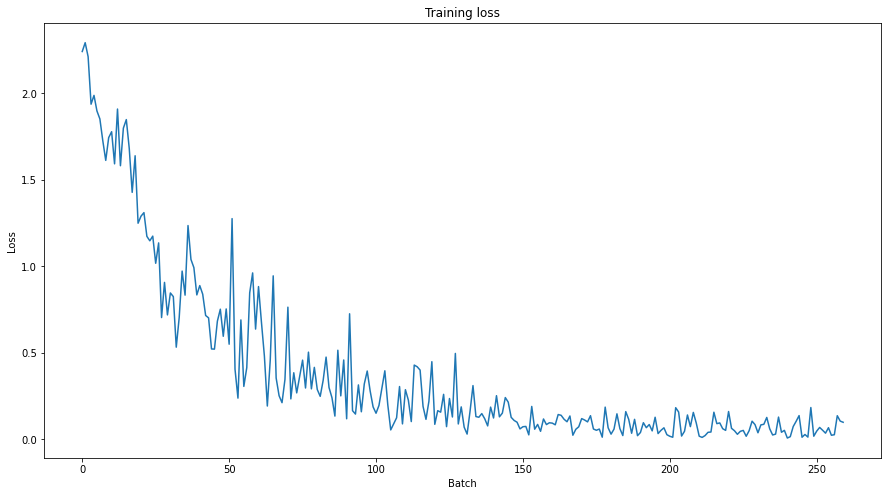

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 20

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))

Classification accuracy using BERT Fine Tuning: 74.69%


In [ ]:
types_df['Type of Tweet'].value_counts()

demand          231
resources       156
advice           68
announcement     45
Name: Type of Tweet, dtype: int64

In [ ]:
tweets = types_df['CleanText']
labels = types_df[['Type of Tweet']].replace(['demand','resources','announcement', 'advice'],[0,1,2,3]) 

tweets = ["[CLS] " + query + " [SEP]" for query in tweets]

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in tweets]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'new', 'york', 'ag', 'suggests', 'emergency', 'housing', 'basement', 'dwell', '##er', 'city', 'ida', 'death', 'hurricane', '##ida', 'ny', 'https', '##tc', '##ou', '##q', '##7', '##j', '##5', '##p', '##na', '##aw', '[SEP]']


In [ ]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [ ]:

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, random_state=2018, test_size=1/9)

train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(train_masks, train_masks, random_state=2018, test_size=1/9)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)
train_labels = torch.tensor(train_labels.to_numpy())
validation_labels = torch.tensor(validation_labels.to_numpy())
test_labels = torch.tensor(test_labels.to_numpy())
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.03907853764338562


Epoch:   3%|▎         | 1/30 [00:06<03:18,  6.85s/it]

Validation Accuracy: 0.6111111111111112
Train loss: 0.15276491233649162


Epoch:   7%|▋         | 2/30 [00:13<03:03,  6.55s/it]

Validation Accuracy: 0.7048611111111112
Train loss: 0.11144032529913463


Epoch:  10%|█         | 3/30 [00:19<02:54,  6.45s/it]

Validation Accuracy: 0.6545138888888888
Train loss: 0.08118246244983031


Epoch:  13%|█▎        | 4/30 [00:25<02:46,  6.42s/it]

Validation Accuracy: 0.7361111111111112
Train loss: 0.09174532822978038


Epoch:  17%|█▋        | 5/30 [00:32<02:39,  6.39s/it]

Validation Accuracy: 0.6857638888888888
Train loss: 0.05160475973612987


Epoch:  20%|██        | 6/30 [00:38<02:32,  6.37s/it]

Validation Accuracy: 0.7013888888888888
Train loss: 0.03369600730589949


Epoch:  23%|██▎       | 7/30 [00:44<02:26,  6.36s/it]

Validation Accuracy: 0.6857638888888888
Train loss: 0.03268758399197115


Epoch:  27%|██▋       | 8/30 [00:51<02:19,  6.35s/it]

Validation Accuracy: 0.6701388888888888
Train loss: 0.039215343162560694


Epoch:  30%|███       | 9/30 [00:57<02:13,  6.35s/it]

Validation Accuracy: 0.6736111111111112
Train loss: 0.048880772557682715


Epoch:  33%|███▎      | 10/30 [01:03<02:06,  6.34s/it]

Validation Accuracy: 0.7013888888888888
Train loss: 0.023680931315399133


Epoch:  37%|███▋      | 11/30 [01:10<02:00,  6.34s/it]

Validation Accuracy: 0.7013888888888888
Train loss: 0.019322044502657194


Epoch:  40%|████      | 12/30 [01:16<01:54,  6.34s/it]

Validation Accuracy: 0.6579861111111112
Train loss: 0.0326082001064116


Epoch:  43%|████▎     | 13/30 [01:22<01:47,  6.34s/it]

Validation Accuracy: 0.7170138888888888
Train loss: 0.015686753895491935


Epoch:  47%|████▋     | 14/30 [01:29<01:41,  6.34s/it]

Validation Accuracy: 0.6736111111111112
Train loss: 0.01820350953270323


Epoch:  50%|█████     | 15/30 [01:35<01:35,  6.35s/it]

Validation Accuracy: 0.7013888888888888
Train loss: 0.020521397191959504


Epoch:  53%|█████▎    | 16/30 [01:41<01:28,  6.35s/it]

Validation Accuracy: 0.7170138888888888
Train loss: 0.01875785392565796


Epoch:  57%|█████▋    | 17/30 [01:48<01:22,  6.35s/it]

Validation Accuracy: 0.7170138888888888
Train loss: 0.022893148837073777


Epoch:  60%|██████    | 18/30 [01:54<01:16,  6.35s/it]

Validation Accuracy: 0.7326388888888888
Train loss: 0.029722403367766395


Epoch:  63%|██████▎   | 19/30 [02:01<01:09,  6.35s/it]

Validation Accuracy: 0.7170138888888888
Train loss: 0.016174421985991873


Epoch:  67%|██████▋   | 20/30 [02:07<01:03,  6.35s/it]

Validation Accuracy: 0.7326388888888888
Train loss: 0.018145201530737374


Epoch:  70%|███████   | 21/30 [02:13<00:57,  6.35s/it]

Validation Accuracy: 0.7326388888888888
Train loss: 0.017885551158822358


Epoch:  73%|███████▎  | 22/30 [02:20<00:50,  6.35s/it]

Validation Accuracy: 0.7326388888888888
Train loss: 0.016201869486114726


Epoch:  77%|███████▋  | 23/30 [02:26<00:44,  6.35s/it]

Validation Accuracy: 0.7326388888888888
Train loss: 0.019619544932188895


Epoch:  80%|████████  | 24/30 [02:32<00:38,  6.34s/it]

Validation Accuracy: 0.7326388888888888
Train loss: 0.017133654972824913


Epoch:  83%|████████▎ | 25/30 [02:39<00:31,  6.34s/it]

Validation Accuracy: 0.7170138888888888
Train loss: 0.01650194340170576


Epoch:  87%|████████▋ | 26/30 [02:45<00:25,  6.33s/it]

Validation Accuracy: 0.7170138888888888
Train loss: 0.015455803511520991


Epoch:  90%|█████████ | 27/30 [02:51<00:19,  6.34s/it]

Validation Accuracy: 0.7170138888888888
Train loss: 0.014539053379289376


Epoch:  93%|█████████▎| 28/30 [02:58<00:12,  6.34s/it]

Validation Accuracy: 0.7170138888888888
Train loss: 0.015860913066157643


Epoch:  97%|█████████▋| 29/30 [03:04<00:06,  6.34s/it]

Validation Accuracy: 0.7170138888888888
Train loss: 0.014325918567080338


Epoch: 100%|██████████| 30/30 [03:10<00:00,  6.36s/it]

Validation Accuracy: 0.7170138888888888


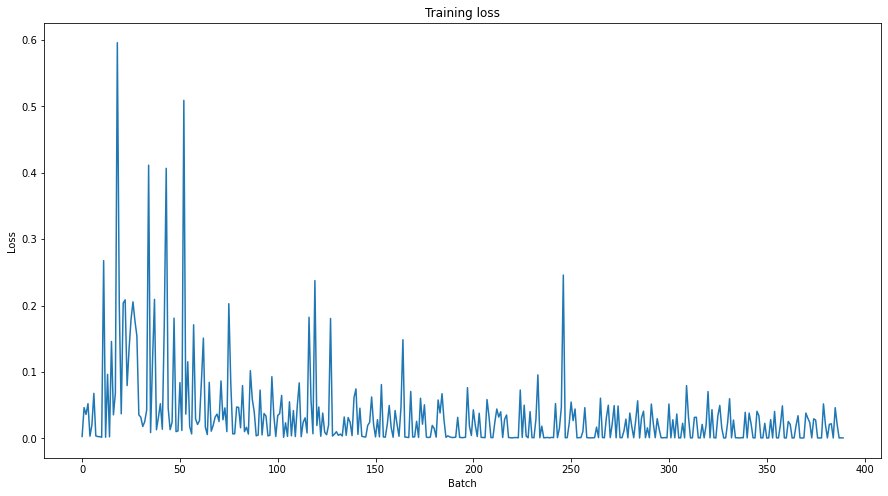

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 30

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))

Classification accuracy using BERT Fine Tuning: 61.18%


In [ ]:
other = target_df[target_df["Demand"] == 'Other']
other['Label'] = other.apply (lambda row: label_need(row), axis=1)
other = other[other['CleanText'].notna()]
other['CleanText'] = other['CleanText'].apply(pre_processing)
other

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Datetime,Tweet Id,Text,Username,Location,FollowersCount,ReplyCount,RetweetCount,Dates,Time,CleanText,Demand,Sentiment140_Sentiment,Label
0,2021-09-03 23:59:59+00:00,1433942885716615173,"@POTUS flying entourage over W Jeff Parish, su...",AnthonyMcAuley2,World,443,0,0,2021-09-03,23:59:59,flying entourage w jeff parish surveying downe...,Other,0,No Need
1,2021-09-03 23:59:19+00:00,1433942716996485123,"Air operations underway @ Grand Isle, LA #Hurr...",ClarkCountyNV,"Las Vegas, Nevada",217434,0,1,2021-09-03,23:59:19,air operation underway grand isle la,Other,4,No Need
2,2021-09-03 23:58:58+00:00,1433942626944884738,I signed up to volunteer by helping man the co...,dikayodata,⚜️🛫⛩,6175,0,0,2021-09-03,23:58:58,i signed volunteer helping man cooling station...,Other,4,No Need
4,2021-09-03 23:57:08+00:00,1433942167152697346,Dammit bobby!\n#HurricaneIda https://t.co/6ljX...,NoTangledKnots,NaN,178,0,0,2021-09-03,23:57:08,dammit bobby,Other,0,No Need
5,2021-09-03 23:56:42+00:00,1433942058495004676,"The ""remnants"" of #HurricaneIda killed more pe...",RogueSailor,⚓ Lost @ Sea ⚓,8771,0,0,2021-09-03,23:56:42,the remnant killed people hurricane,Other,0,No Need
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42533,2021-08-26 15:46:12+00:00,1430919515127300098,#HURRICANEIDA Watch! FULL #VIDEO BREAKDOWN Now...,In2ThinAir,"North East, US",767,0,0,2021-08-26,15:46:12,watch full breakdown now soon 2b may see via,Other,4,No Need
42535,2021-08-26 15:06:29+00:00,1430909520868433920,@NHC_Atlantic forecasts TD Nine to become #Hur...,TylerJStanfield,"Blacksburg, VA",1857,0,0,2021-08-26,15:06:29,forecast td nine become saturday explicitly sh...,Other,0,No Need
42537,2021-08-26 14:47:45+00:00,1430904806038642696,@ezrocks0011 @mal1976retaf @Lisaisback21 @fric...,enufs_enuf,Nunya TX,1228,1,2,2021-08-26,14:47:45,btw upgraded will probably within next couple ...,Other,4,No Need
42538,2021-08-26 13:28:18+00:00,1430884811292487682,Sorry not sorry.\n\n#Louisiana #SWLA #LakeChar...,unclejeet,NaN,788,0,1,2021-08-26,13:28:18,sorry sorry,Other,0,No Need


In [ ]:
tweets = other['CleanText']
labels = other[['Label']].replace(['No Need','Electricity','Food', 'Shelter', 'Water', 'Medicine'],[0,1,2,3,4,5]) 


# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in tweets]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels.to_numpy())
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))

Classification accuracy using BERT Fine Tuning: 0.00%


In [ ]:
preds = pd.DataFrame(flat_predictions).replace([0,1,2,3,4,5], ['No Need','Electricity','Food', 'Shelter', 'Water', 'Medicine']) 

In [ ]:
preds.value_counts()

No Need        17894
Food           11638
Shelter         2335
Electricity     1512
Water             29
Medicine           7
dtype: int64

In [ ]:
preds = np.array(preds)

In [ ]:
preds

array([['No Need'],
       ['No Need'],
       ['No Need'],
       ...,
       ['No Need'],
       ['Food'],
       ['No Need']], dtype=object)

In [ ]:
other['PRED'] = preds

In [ ]:
other

,Datetime,Tweet Id,Text,Username,Location,FollowersCount,ReplyCount,RetweetCount,Dates,Time,CleanText,Demand,Sentiment140_Sentiment,Label,PRED
0,2021-09-03 23:59:59+00:00,1433942885716615173,"@POTUS flying entourage over W Jeff Parish, su...",AnthonyMcAuley2,World,443,0,0,2021-09-03,23:59:59,flying entourage w jeff parish surveying downe...,Other,0,No Need,No Need
1,2021-09-03 23:59:19+00:00,1433942716996485123,"Air operations underway @ Grand Isle, LA #Hurr...",ClarkCountyNV,"Las Vegas, Nevada",217434,0,1,2021-09-03,23:59:19,air operation underway grand isle la,Other,4,No Need,No Need
2,2021-09-03 23:58:58+00:00,1433942626944884738,I signed up to volunteer by helping man the co...,dikayodata,⚜️🛫⛩,6175,0,0,2021-09-03,23:58:58,i signed volunteer helping man cooling station...,Other,4,No Need,No Need
4,2021-09-03 23:57:08+00:00,1433942167152697346,Dammit bobby!\n#HurricaneIda https://t.co/6ljX...,NoTangledKnots,NaN,178,0,0,2021-09-03,23:57:08,dammit bobby,Other,0,No Need,Food
5,2021-09-03 23:56:42+00:00,1433942058495004676,"The ""remnants"" of #HurricaneIda killed more pe...",RogueSailor,⚓ Lost @ Sea ⚓,8771,0,0,2021-09-03,23:56:42,the remnant killed people hurricane,Other,0,No Need,Electricity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42533,2021-08-26 15:46:12+00:00,1430919515127300098,#HURRICANEIDA Watch! FULL #VIDEO BREAKDOWN Now...,In2ThinAir,"North East, US",767,0,0,2021-08-26,15:46:12,watch full breakdown now soon 2b may see via,Other,4,No Need,Food
42535,2021-08-26 15:06:29+00:00,1430909520868433920,@NHC_Atlantic forecasts TD Nine to become #Hur...,TylerJStanfield,"Blacksburg, VA",1857,0,0,2021-08-26,15:06:29,forecast td nine become saturday explicitly sh...,Other,0,No Need,Food
42537,2021-08-26 14:47:45+00:00,1430904806038642696,@ezrocks0011 @mal1976retaf @Lisaisback21 @fric...,enufs_enuf,Nunya TX,1228,1,2,2021-08-26,14:47:45,btw upgraded will probably within next couple ...,Other,4,No Need,No Need
42538,2021-08-26 13:28:18+00:00,1430884811292487682,Sorry not sorry.\n\n#Louisiana #SWLA #LakeChar...,unclejeet,NaN,788,0,1,2021-08-26,13:28:18,sorry sorry,Other,0,No Need,Food


In [ ]:
other.to_csv("./data/BERT_others_preds.csv")